In [ ]:
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt

# Загрузка и просмотр данных

In [ ]:
import os #чтение файлов и структуры директорий

In [21]:
images = os.listdir("train/train")
categories = []
for image in images:
    category = image.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': images,
    'category': categories
})


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


# Предобработка данных
произведем нормализацию;
заменила название категорий на cat и dog так как у генератора class_mode="categorical"

разбила размеченные данные на тренировочное и валидационные множества, добавила индексы

In [6]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

batch_size = 15 # количество тренировочных изображений для обработки перед обновлением параметров модели
IMAGE_SIZE = (96, 96)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
FAST_RUN = False

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory="train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [25]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


# Построение модели

In [27]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 - 2 класса

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 70688)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               36192768  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=7)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

# Обучение модели

In [29]:
epochs=3 if FAST_RUN else 100
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/100
1333/1333 [==============================] - 1098s 824ms/step - loss: 0.7398 - accuracy: 0.6388 - val_loss: 0.6254 - val_accuracy: 0.6773
Epoch 2/100
1333/1333 [==============================] - 1027s 770ms/step - loss: 0.6253 - accuracy: 0.6712 - val_loss: 0.5717 - val_accuracy: 0.7163
Epoch 3/100
1333/1333 [==============================] - 787s 591ms/step - loss: 0.6209 - accuracy: 0.6777 - val_loss: 0.6299 - val_accuracy: 0.6787
Epoch 4/100
1333/1333 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6817
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 765s 574ms/step - loss: 0.6171 - accuracy: 0.6817 - val_loss: 0.7195 - val_accuracy: 0.6456
Epoch 5/100
1333/1333 [==============================] - 755s 567ms/step - loss: 0.5857 - accuracy: 0.7039 - val_loss: 0.5624 - val_accuracy: 0.7291
Epoch 6/100
1333/1333 [==============================] - 742s 557ms/step - loss: 0.583

In [30]:
model.save_weights("easy_model.h5")

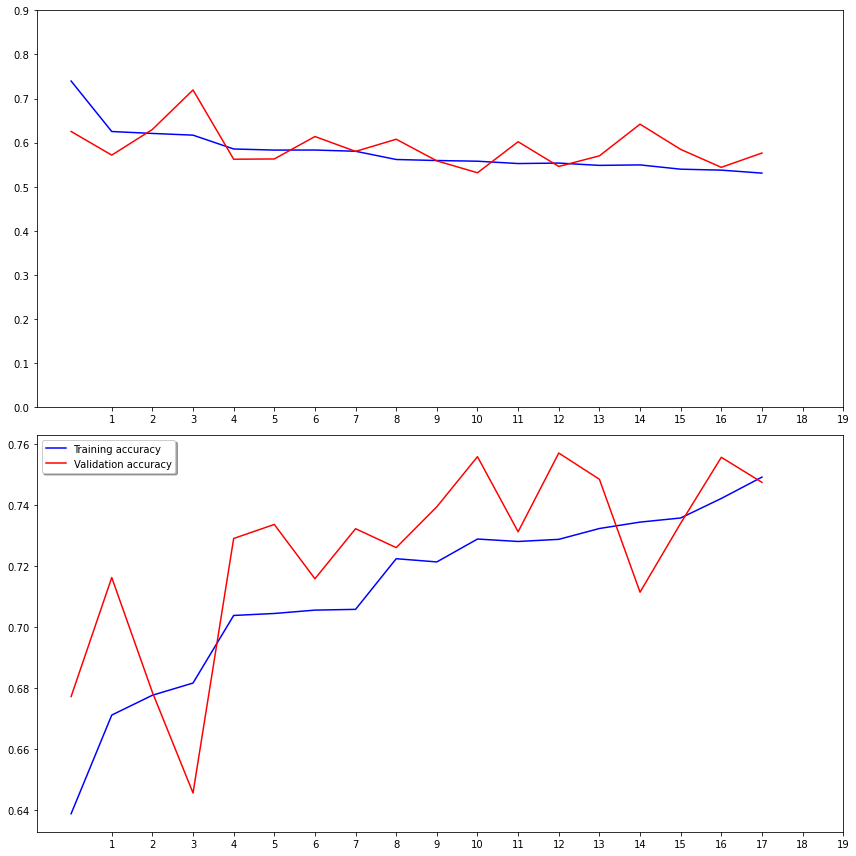

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 20))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 20))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()